# JPK AFM data analysis for liquid samples

## Import libraries
Run this ONLY ONCE. Always restart kernel before running.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg

import sys
import os
import pandas as pd
from datetime import datetime
from igor import binarywave
from PyQt5.QtWidgets import QApplication, QFileDialog, QListView, QTreeView, QAbstractItemView
#from IPython.display import Image
import matplotlib.pyplot as plt
import wetting, surfevol

app = QApplication(sys.argv)
plt.close('all')

#function to select multiple folders from dialog
def get_directories(caption=""):
    file_dialog = QFileDialog(caption=caption)
    file_dialog.setFileMode(QFileDialog.DirectoryOnly)
    file_dialog.setOption(QFileDialog.DontUseNativeDialog, True)
    file_view = file_dialog.findChild(QListView, 'listView')

    if file_view:
        file_view.setSelectionMode(QAbstractItemView.MultiSelection)
    f_tree_view = file_dialog.findChild(QTreeView)
    if f_tree_view:
        f_tree_view.setSelectionMode(QAbstractItemView.MultiSelection)

    if file_dialog.exec():
        paths = file_dialog.selectedFiles()
    else:
        paths = []

    return paths

#recognize if *.ibw file contains image data or force data
def categorize_ibw(filepath):
    ibw = binarywave.load(filepath)
    wdata = ibw["wave"]["wData"]
    meta_keys = []
    for line in str(ibw["wave"]["note"]).split("\\r"):
        if line.count(":"):
            key, val = line.split(":", 1)
            meta_keys.append(key)

    #CHECK THIS! MIGHT NOT WORK FOR SOME DATA
    if 'ForceDist' in meta_keys:
        file_cat = 'force'
    else:
        file_cat = 'image'
        
    return file_cat        

## Surface Evolver simulation data files

In [27]:
plt.close('all')

# simu_folderpath = 'E:/Work/Surface Evolver/afm_pyramid/data/20221024_cone_fd/TA_15/' #20220906_cone_sym_height0,20220823_pyramid_sym_height0_ca30,20220822_tipangle_sym_height0,20220325_rfesp_np_fd

# #combine simulation data for tip geometry
# simu_df, simu_df_anal, fig_list = surfevol.combine_simul_dirs(simu_folderpath, 
#                                                               fd_fit_order=2, plot=True)

# #show plots below
# for f in fig_list:
#     display(f)
# plt.close('all')

simu_pyr = pd.read_excel('pyramid_simulation.xlsx', engine = 'openpyxl')
simu_pyr['Tip shape'] = 'Pyramid'
simu_cone = pd.read_excel('cone_simulation.xlsx', engine = 'openpyxl')
simu_cone['Tip shape'] = 'Cone'

simu_df = simu_pyr.append(simu_cone)

## Run Surface Tension code
Only works with classic Jupyter Notebook, not JupyterLab

In [88]:
%%javascript
Jupyter.notebook.execute_cells([8,10,12,14,16])

<IPython.core.display.Javascript object>

## JPK data raw files

In [89]:
jpk_file_paths, _ = QFileDialog.getOpenFileNames(caption='Select JPK data files') #JPK data (*.jpk,*.jpk-qi-data,*.jpk-force)
output_dir = QFileDialog.getExistingDirectory(caption='Select output data folder') #output folder
        
#separate image data and force data files
img_file_paths = []
fd_file_paths = []
for filepath in jpk_file_paths:
    file_ext = filepath.split('.')[-1]
    if file_ext in ['jpk', 'jpk-qi-data']:
        img_file_paths.append(filepath)
    elif file_ext in ['jpk-force']:
        fd_file_paths.append(filepath)
    elif file_ext in ['ibw']: #change this
        file_cat = categorize_ibw(filepath)
        if file_cat == 'image':
            img_file_paths.append(filepath)
        elif file_cat == 'force':
            fd_file_paths.append(filepath)
        
#make output directory
if output_dir == '':
        output_dir = os.path.dirname(jpk_file_paths[0]) + '/analysis' #default "analysis" folder
output_paths = []
for img_file_path in img_file_paths:
    file_name = os.path.basename(img_file_path)
    timestamp = datetime.today().strftime('%y%m%d-%H%M%S')
    output_path = f'{output_dir}/{file_name}_results_{timestamp}'
    os.makedirs(output_path, exist_ok=True)
    output_paths.append(output_path)

print('Image data:\n', img_file_paths, '\nForce data:\n', fd_file_paths, '\nOutput folder:\n', output_paths)

Image data:
 ['E:/Work/AFM/20221225 water_OLTESPA_pegbrush/save_area2-2022.12.25-17.01.17.226.jpk'] 
Force data:
 ['E:/Work/AFM/20221225 water_OLTESPA_pegbrush/force-save_area2_drop-2022.12.25-17.03.04.585.jpk-force'] 
Output folder:
 ['E:/Work/AFM/20221225 water_OLTESPA_pegbrush/analysis/save_area2-2022.12.25-17.01.17.226.jpk_results_221228-173004']


## AFM image

Image file: E:/Work/AFM/20221225 water_OLTESPA_pegbrush/save_area2-2022.12.25-17.01.17.226.jpk
Output folder: E:/Work/AFM/20221225 water_OLTESPA_pegbrush/analysis/save_area2-2022.12.25-17.01.17.226.jpk_results_221228-173004


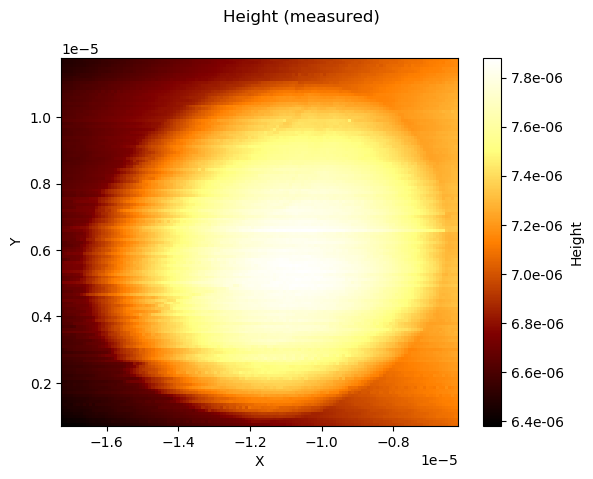

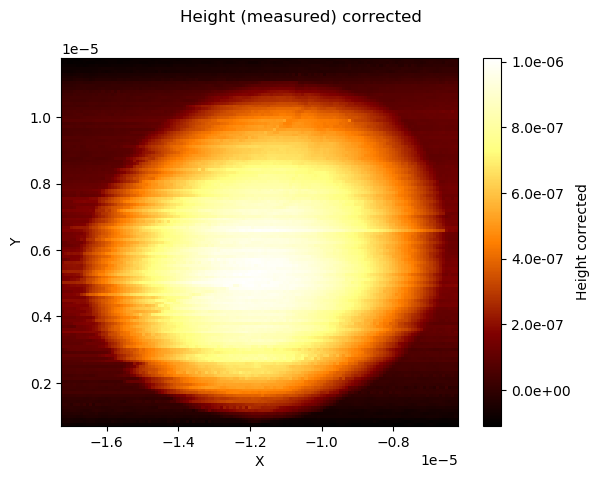

In [90]:
plt.close('all')
for img_file_path, output_path in zip(img_file_paths, output_paths):
    print('Image file:', img_file_path)
    print('Output folder:', output_path)
    afm_data, anal_data_h, fig_list =  wetting.get_afm_image(img_file_path, output_path, 
                                                             level_order=2, jump_tol=0.9)
    for fig in fig_list:
        display(fig)

plt.close('all')

## Get liquid drop properties

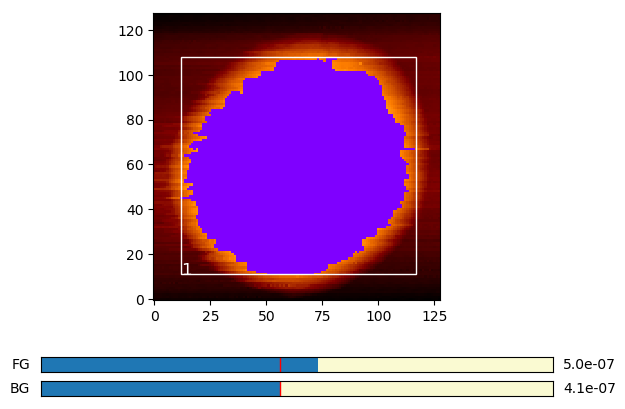

,Label,Curvature,Contact Radius,Max Height,Max Height raw,Volume,Volume raw,Drop contact angle,s,R/d,AFM file
0,1,0.000026,0.000007,9.065559e-07,0.000001,6.755191e-17,3.964824e-17,15.039711,0.000003,7.575467,E:/Work/AFM/20221225 water_OLTESPA_pegbrush/sa...


In [91]:
plt.close('all')
#drop analysis of AFM data
drop_df, img_anal, fig_list = wetting.get_drop_prop(afm_data, anal_data_h, output_paths[0])
drop_df['AFM file'] = img_file_paths[0]
for fig in fig_list:
    display(fig)
display(drop_df)
plt.close('all')

## Analyze force distance curves

Force file: E:/Work/AFM/20221225 water_OLTESPA_pegbrush/force-save_area2_drop-2022.12.25-17.03.04.585.jpk-force
jumpin distance 3.779311837896697e-07
Fit distance 1.600039302036189e-07
FD wetted length: 8.802941039815463e-08
energy 1 5.790749574396575e-16


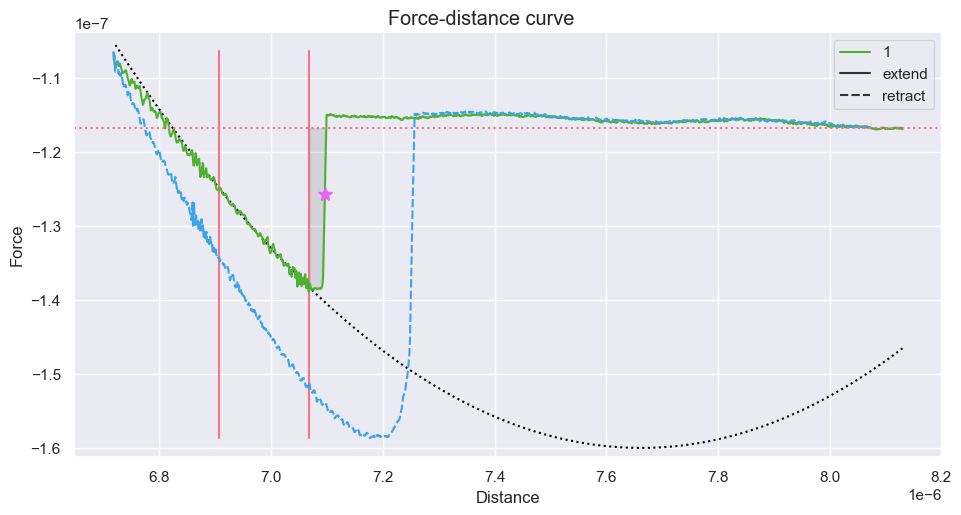

,Label,Adhesion (FD),Jumpin distance (FD),Slope (FD),Wetted length (FD),Fit distance (FD),Adhesion energy (FD),FD X position,FD Y position,FD file
0,1,2.212460e-08,3.779312e-07,-0.082986,8.802941e-08,1.600039e-07,5.790750e-16,-0.000011,0.000006,E:/Work/AFM/20221225 water_OLTESPA_pegbrush/fo...


In [92]:
plt.close('all')
fd_drop_df, fdfit_dict, fddata_dict, fig_list = wetting.analyze_drop_fd(fd_file_paths, afm_data, img_anal,
                                                                        force_cycle = 'approach', fit_order = 2,
                                                                        output_path = output_paths[0])

for fig in fig_list:
    #fig = Image(fig_path, width=400, height=400)
    display(fig)
display(fd_drop_df)

## Droplet surface tension calculation

In [93]:
#based on fixed AFM tip angle and contact angle 
plt.close('all')
plt.style.use('seaborn-bright')
contact_angle = 30 #Set fixed value to calculate its corresponsing surface tension
tip_angle_dict = {'Cone':7, 'Pyramid':20} #half angle of geometry
transition_height = 700e-9
#combine droplet image and force result data
afm_df = drop_df.set_index('Label').join(fd_drop_df.set_index('Label'), how='right')

#calculate surface tension (from rupture distance)
output_df = wetting.get_surface_tension(afm_df, simu_df,contact_angle,tip_angle_dict,
                                        transition_height,fd_file_paths, output_paths[0], True)

Label
1    23.730138
Name: Surface Tension FD (mN), dtype: float64
    index  Unnamed: 0  Contact_Radius  Height  Force_Eng  Force_Calc  \
0     273           0        0.661050       0  -0.113255   -0.176410   
1     274           1        0.775658       0  -0.115544   -0.167432   
2     275           2        0.909262       0  -0.118252   -0.159183   
3     276           3        1.065688       0  -0.121546   -0.149711   
4     277           4        1.248905       0  -0.125198   -0.139729   
5     278           5        1.462786       0  -0.128725   -0.129806   
6     279           6        1.710910       0  -0.132281   -0.120397   
7     280           7        1.996452       0  -0.135792   -0.111756   
8     281           8        2.322187       0  -0.139323   -0.103742   
9     282           9        2.690561       0  -0.142526   -0.096547   
10    283          10        3.103803       0  -0.145656   -0.089838   
11    284          11        3.564011       0  -0.148597   -0.083900 

In [14]:
plt.close('all')
plt.style.use('seaborn-bright')
contact_angle = 30 #Set fixed value to calculate its corresponsing surface tension

#combine droplet image and force result data
afm_df = drop_df.set_index('Label').join(fd_drop_df.set_index('Label'), how='right')

#calculate surface tension (from rupture distance)
output_df = wetting.get_surface_tension3(afm_df, simu_df_anal,contact_angle,
                                          fd_file_paths, output_paths[0], True)

#output_df_filtered = output_df.dropna(subset=['FD file'])


# calculate surface tension from slopes of linear FD fitting
output_df2 = wetting.get_surface_tension2(afm_df, simu_df,
                                         tolerance=0.5,
                                         fd_file_paths=fd_file_paths,
                                         file_path=output_paths[0], save=True)
#output_df_filtered2 = output_df2[output_df['FD file'] != '']

# calculate surface tension by complete FD fitting using 2nd order poly approximation
output_df3, fig = wetting.get_surface_tension4(afm_df, simu_df, fdfit_dict,fddata_dict,
                                              file_path=output_paths[0], save=True)

ax = output_df.plot(x='Contact Radius', y=['Surface Tension (rupture, mN)','Surface Tension (fixed, mN)'],
                             marker = "o", ls="")
ax.plot(output_df2['Contact Radius'],output_df2['Surface Tension FD (mN)'],
        label="Surface Tension (slope, mN)", marker = "o", ls="")
ax.plot(output_df3['Contact Radius'],output_df3['Surface Tension (error min, mN)'],
        label="Surface Tension (polyfit, mN)", marker = "o", ls="")
ax.legend()

ax.ticklabel_format(axis='x', style='sci', scilimits=(-6,-6))
#show and save plot
fig1 = ax.get_figure()
display(fig1)
fig1.savefig(f'{output_paths[0]}/surface_tension.png', bbox_inches = 'tight',
             transparent = False)

plot_vars = ['Drop contact angle','Tip contact angle (rupture)',
             'Adhesion (FD)', 'Wetted length (FD)']
ax = output_df.plot(x='Contact Radius', y=plot_vars,title = plot_vars,
                             marker = "o", ls="", subplots=True, layout=(2,2), figsize=(11,10),
                             legend=False)
#number formatting
ax[1][0].ticklabel_format(axis='y', style='sci', scilimits=(-9,-9))
ax[1][1].ticklabel_format(axis='y', style='sci', scilimits=(-9,-9))
ax[1][1].ticklabel_format(axis='x', style='sci', scilimits=(-6,-6))
#show and save plot
fig2 = ax[0][0].get_figure()
display(fig2)
fig2.savefig(f'{output_paths[0]}/other_results.png', bbox_inches = 'tight',
             transparent = False)

display(output_df)
display(output_df2)
display(output_df3)
display(fig)
fig.savefig(f'{output_paths[0]}/polyfit_result.png', bbox_inches = 'tight',
            transparent = False)
plt.close('all')

NameError: name 'simu_df_anal' is not defined

## Combine results from different folders

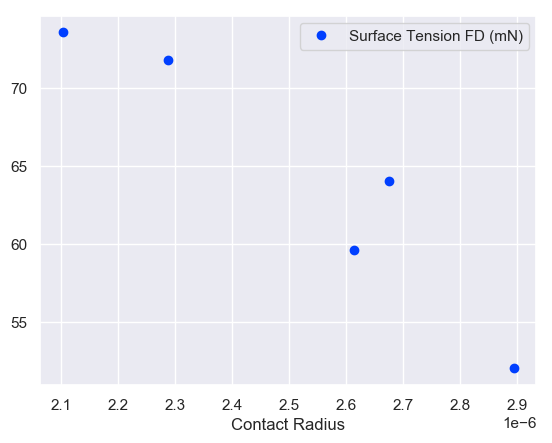

,Label,Curvature,Contact Radius,Max Height,Max Height raw,Volume,Volume raw,Drop contact angle,s,R/d,...,FD X position,FD Y position,FD file,Tip angle,F_fit,yd/F,Surface Tension FD (mN),Simulation contact angle,Folder name,File path
0,1,0.000015,0.000002,1.474902e-07,1.617569e-07,1.026019e-18,7.686309e-19,8.024625,6.256847e-07,14.256639,...,0.000019,0.000003,E:/Work/AFM/20221217 water_RFESPA_pegbrush/for...,10,-0.404313,0.393643,73.576471,30,save_area1-2022.12.17-19.28.50.864.jpk_results...,E:/Work/AFM/20221217 water_RFESPA_pegbrush/ana...
0,1,0.000014,0.000002,1.826996e-07,2.077603e-07,1.505385e-18,1.195967e-18,9.131363,7.109728e-07,12.522655,...,-0.000003,-0.000019,E:/Work/AFM/20221217 water_RFESPA_pegbrush/for...,10,-0.343889,0.462809,71.795315,30,save_area1-2022.12.17-18.45.46.138.jpk_results...,E:/Work/AFM/20221217 water_RFESPA_pegbrush/ana...
0,1,0.000020,0.000003,1.715823e-07,1.904066e-07,1.843756e-18,1.308464e-18,7.512050,7.606852e-07,15.232507,...,-0.000020,-0.000007,E:/Work/AFM/20221217 water_RFESPA_pegbrush/for...,10,-0.451987,0.352123,59.650735,30,save_area1-2022.12.17-19.06.37.898.jpk_results...,E:/Work/AFM/20221217 water_RFESPA_pegbrush/ana...
0,1,0.000017,0.000003,2.158185e-07,2.373662e-07,2.429978e-18,1.831443e-18,9.227314,8.340100e-07,12.391881,...,0.000009,-0.000018,E:/Work/AFM/20221217 water_RFESPA_pegbrush/for...,10,-0.340414,0.467533,64.042036,30,save_area1-2022.12.17-18.56.31.157.jpk_results...,E:/Work/AFM/20221217 water_RFESPA_pegbrush/ana...
0,1,0.000023,0.000003,1.836149e-07,2.124428e-07,2.419259e-18,1.664208e-18,7.260106,8.327818e-07,15.762607,...,-0.000001,0.000011,E:/Work/AFM/20221217 water_RFESPA_pegbrush/for...,10,-0.482674,0.329736,52.032503,30,save_area1-2022.12.17-19.16.34.334.jpk_results...,E:/Work/AFM/20221217 water_RFESPA_pegbrush/ana...


In [111]:
plt.cla()
plt.clf()
plt.close('all')
folder_paths = get_directories("Select analysis result folder (containing output Excel file)")
summary_df = wetting.combine_result_spreadsheets(folder_paths)
summary_df = summary_df[summary_df['FD file'] != '']

surf_ten_label = [#'Surface Tension (rupture, mN)', 
                  #'Surface Tension (fixed, mN)',
                  'Surface Tension FD (mN)', 
                  #'Surface Tension (error min, mN)'
                ]
#summary_df = summary_df[summary_df[surf_ten_label] != 0]
#summary_df.replace(0, np.nan, inplace=True)
timestamp = datetime.today().strftime('%y%m%d-%H%M%S')
summary_df.to_excel(f'{output_dir}/summary_data_all_{timestamp}.xlsx', index=None)

ax = summary_df.plot(x='Contact Radius', 
                     y=surf_ten_label,
                     marker = "o", ls="")

ax.ticklabel_format(axis='x', style='sci', scilimits=(-6,-6))
#show and save plot
fig3 = ax.get_figure()
fig3.savefig(f'{output_dir}/summary_plot_all_{timestamp}.png', bbox_inches = 'tight',
             transparent = False)
display(fig3)
display(summary_df)
plt.close('all')

## Combine multiple FD curves

In [84]:
plt.close('all')
# combine multiple fd curves
output_path = ''
fd_file_paths, _ = QFileDialog.getOpenFileNames()
wetting.combine_fd(fd_file_paths, zero_shift=True, 
                   output_dir=output_path,save=False)
#wetting.get_adhesion_from_fd(fd_file_paths)

Raw
Defl
ZSnsr


## Optional codes

In [ ]:
# calculate contact angle from fd curve
label = 5 #INPUT
label_df = drop_df[drop_df['Label']==label]
s = label_df['s'].iloc[0]
R = round(label_df['R/s'].iloc[0])
contact_angle = wetting.get_contact_angle(fd_file_paths[0], simu_df,
                                         R, s, fit_index=5000)

